<a href="https://colab.research.google.com/github/GrizzlyToast/ML_Practise/blob/main/COMP551_assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acquire the Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)


def load_fashion_mnist(data_augmentation=False, normalize=True):

    # Load MNIST data as tensors
    basic_transform = transforms.Compose([transforms.ToTensor()])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=basic_transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=basic_transform)

    # Split into 70/30 split for training and validation
    train_size = int(0.7 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Convert datasets into tensors
    X_train = torch.stack([x for x, _ in train_dataset])
    y_train = torch.tensor([y for _, y in train_dataset])

    X_val = torch.stack([x for x, _ in val_dataset])
    y_val = torch.tensor([y for _, y in val_dataset])

    X_test = torch.stack([x for x, _ in test_dataset])
    y_test = torch.tensor([y for _, y in test_dataset])

    # Implement data augmentation
    if data_augmentation:

        # Applies one of these augmentation methods
        augment_transform = transforms.Compose([transforms.RandomRotation(10), transforms.RandomHorizontalFlip(), transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), transforms.ToTensor()])

        augmented_images = []

        for img in X_train:
            # Convert to PIL to apply the augmentation
            img_pil = transforms.ToPILImage()(img)
            img_aug = augment_transform(img_pil)
            augmented_images.append(img_aug)

        # Concatenate original and augmented data
        X_train = torch.cat([X_train, torch.stack(augmented_images)])
        y_train = torch.cat([y_train, y_train]) # Duplicate labels since each X_train has been augmented once

    # Find mean and std of training data
    mean = X_train.mean().item()
    std = X_train.std().item()



    # Normalize training, validation and test sets accordingly
    if normalize:
      X_train = (X_train - mean) / std
      X_val = (X_val - mean) / std
      X_test = (X_test - mean) / std


    # Convert to numpy
    X_train = X_train.numpy()
    y_train = y_train.numpy()
    X_val = X_val.numpy()
    y_val = y_val.numpy()
    X_test = X_test.numpy()
    y_test = y_test.numpy()

    # Flatten datasets
    # (list of vector's (contiguous sets of pixels) representing each image)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)


    # Non-flattened dataset has dimensions (# inputs, # channels, image size) . In this case there is only one channel since the images are grayscale
    print(f"Dataset shape: Training: {X_train.shape}, Validation: {X_val_flat.shape}, Test: {X_test_flat.shape}")
    print(f"Flattened dataset shape: Training: {X_train_flat.shape}, Validation: {X_val_flat.shape}, Test: {X_test_flat.shape}")


    return X_train_flat, y_train, X_val_flat, y_val, X_test_flat, y_test, X_train, X_val, X_test


In [ ]:
# Load the data (without augmentation to see original distribution)
X_train_flat, y_train, X_val_flat, y_val, X_test_flat, y_test, X_train, X_val, X_test = load_fashion_mnist(data_augmentation=False, normalize=False)

<built-in method size of Tensor object at 0x7dafc4d54730>
Dataset shape: Training: (42000, 1, 28, 28), Validation: (18000, 784), Test: (10000, 784)
Flattened dataset shape: Training: (42000, 784), Validation: (18000, 784), Test: (10000, 784)


In [ ]:
print(X_train.mean())


0.28568938


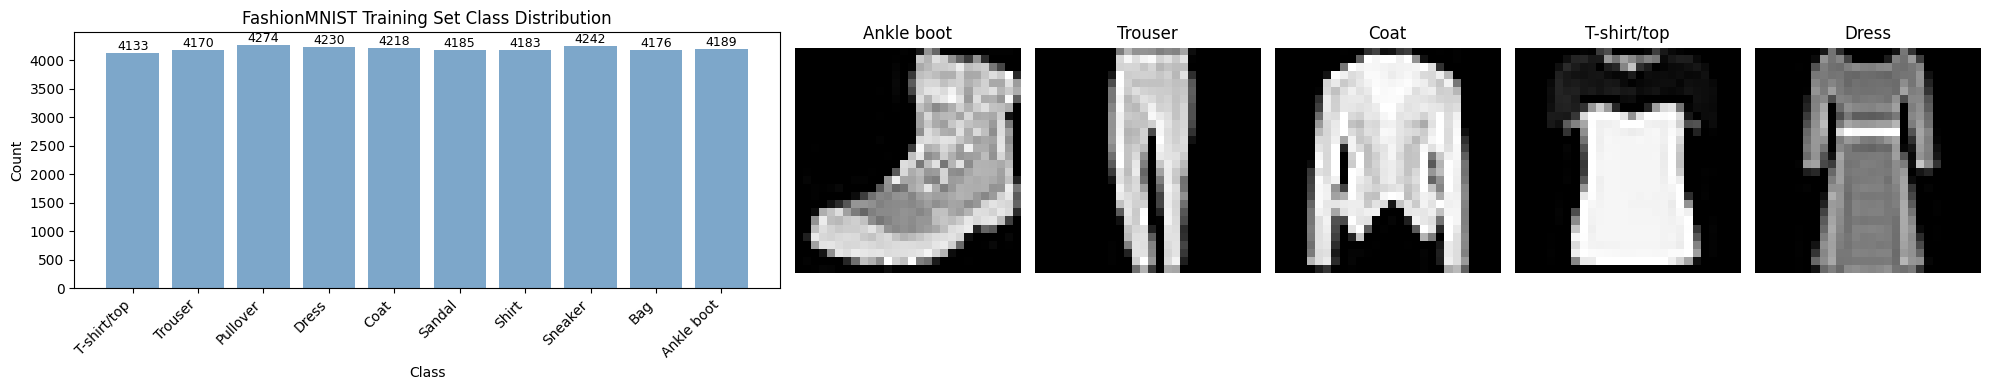

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig = plt.figure(figsize=(20, 4))


plt.subplot(1, 8, (1, 3))
unique, counts = np.unique(y_train, return_counts=True)
bars = plt.bar(unique, counts, color='steelblue', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('FashionMNIST Training Set Class Distribution')
plt.xticks(unique, class_names, rotation=45, ha='right')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=9)


num_samples = 5
sample_indices = np.random.choice(len(X_train), num_samples, replace=False)

for i, idx in enumerate(sample_indices):
    plt.subplot(1, 8, i + 4)  # Positions 6, 7, 8, 9, 10
    img = X_train[idx].squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f'{class_names[y_train[idx]]}')
    plt.axis('off')

plt.tight_layout()
plt.savefig('fashion_mnist_visualization.svg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
X_train_flat, y_train, X_val_flat, y_val, X_test_flat, y_test, X_train, X_val, X_test = load_fashion_mnist(data_augmentation=False)

Dataset shape: Training: (42000, 1, 28, 28), Validation: (18000, 784), Test: (10000, 784)
Flattened dataset shape: Training: (42000, 784), Validation: (18000, 784), Test: (10000, 784)


# Implement a Multilayer Perceptron

In [ ]:
import networkx as nx

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def tanh(z):
    return np.tanh(z)

def tanh_derivative(z):
    return 1 - np.tanh(z)**2

def leaky_relu(z, gamma=0.01):
    return np.where(z > 0, z, gamma * z)

def leaky_relu_derivative(z, gamma=0.01):
    return np.where(z > 0, 1, gamma)


class MLP:

    def __init__(self, input_size, hidden_sizes, output_size, activation='relu'):
        self.activation_name = activation
        self.layers = []

        # Array of layer sizes
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        print("layer sizes", layer_sizes)

        self.weights = []
        self.biases = []

        for i in range(len(layer_sizes) - 1):
            # Initialize weights and biases

            # Weights are initialised as (input size, output size) to match dimensions of X (instances, features)
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.1
            b = np.zeros((1, layer_sizes[i+1]))

            self.weights.append(w)
            self.biases.append(b)

        # Define activation function and its derivative
        if activation == 'relu':
            self.activation = relu
            self.activation_derivative = relu_derivative
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_derivative = tanh_derivative
        elif activation == 'leaky_relu':
            self.activation = lambda z: leaky_relu(z)
            self.activation_derivative = lambda z: leaky_relu_derivative(z)

    def build_graph(self):

        # Build acyclic computational graph
        G = nx.DiGraph()

        node_id = 0

        # Input layer
        G.add_node(node_id, type='input', name='X')
        node_id += 1

        # Hidden layers
        for i in range(len(self.weights) - 1):

            # Linear transformation: z = X @ W + b
            G.add_node(node_id, type='linear', layer=i, name=f'z_{i}')
            G.add_edge(node_id - 1, node_id)
            node_id += 1

            # Activation: a = activation(z)
            G.add_node(node_id, type='activation', layer=i, name=f'a_{i}')
            G.add_edge(node_id - 1, node_id)
            node_id += 1

        # Output layer: z = X @ W + b
        G.add_node(node_id, type='linear', layer=len(self.weights)-1, name='last layer')
        G.add_edge(node_id - 1, node_id)
        node_id += 1

        # Softmax + Cross-Entropy Loss
        G.add_node(node_id, type='softmax_loss', name='softmax_cross_entropy')
        G.add_edge(node_id - 1, node_id)

        self.graph = G
        self.n_nodes = node_id + 1
        return G


    def forward(self, X):
        self.values = {}
        self.values[0] = X


        node_id = 1

        # Hidden layers
        for i in range(len(self.weights) - 1):

            # Linear: z = X @ W + b
            prev_value = self.values[node_id - 1]

            z = np.matmul(prev_value, self.weights[i]) + self.biases[i]
            self.values[node_id] = z

            node_id += 1

            # Activation: a = activation(z)
            a = self.activation(z)
            self.values[node_id] = a

            node_id += 1

        # Output layer
        prev_value = self.values[node_id - 1]


        z = np.matmul(prev_value, self.weights[-1]) + self.biases[-1]
        self.values[node_id] = z

        node_id += 1

        # Softmax (computed for prediction, stored for loss)
        y_pred = softmax(z)
        self.values[node_id] = y_pred

        return y_pred



    def backward(self, X, y):
        # Backpropagation formula: a_bar_current = a_bar_child * (d child/d current)

        m = X.shape[0]

        # Gradient of dL/d_ for each node in the graph
        self.grads = {}
        self.weight_grads = {i: np.zeros_like(self.weights[i]) for i in range(len(self.weights))}
        self.bias_grads = {i: np.zeros_like(self.biases[i]) for i in range(len(self.biases))}

        # Start at the last node with dL/dL = 1
        loss_node_id = self.n_nodes - 1
        self.grads[loss_node_id] = 1.0

        topological_order = list(nx.topological_sort(self.graph))

        # Iterate through the nodes in reverse order
        for current_id in reversed(topological_order[:-1]):

            if current_id == 0:  # Input node
                break

            # Fetch the single child node
            children = list(self.graph.successors(current_id))
            child_id = children[0]

            # Fetch the gradient of the child node
            child_grad = self.grads[child_id]

            # Check the type of child to determine the local gradient
            child_type = self.graph.nodes[child_id]['type']

            # Calculate the local gradient
            if child_type == 'softmax_loss':
                # dL/dz = (softmax(z) - y) / m
                y_pred = self.values[child_id]
                local_grad = (y_pred - y) / m
                self.grads[current_id] = child_grad * local_grad

            elif child_type == 'activation':
                # da/dz = derivative of activation on z
                z = self.values[current_id]
                local_grad = self.activation_derivative(z)
                self.grads[current_id] = child_grad * local_grad

            elif child_type == 'linear':
                # dz/dX = W^T
                layer = self.graph.nodes[child_id]['layer']
                self.grads[current_id] = np.matmul(child_grad, self.weights[layer].T)

            # If the current node is linear need to also compute the gradients of the weights and biases
            current_type = self.graph.nodes[current_id]['type']

            if current_type == 'linear':
                # z = WX + b
                layer = self.graph.nodes[current_id]['layer']

                # Get parent (input to this linear layer)
                parents = list(self.graph.predecessors(current_id))
                parent_id = parents[0]
                layer_input = self.values[parent_id]

                # Gradient in terms of the output: dL/dz
                gradient_to_output = self.grads[current_id]

                # dz/dW = X^T
                # Thus dL/dW = dL/dz * dz/dW
                # X is the input to the layer originating from the parent node
                self.weight_grads[layer] = np.matmul(layer_input.T, gradient_to_output)

                # dz/db = I, need to sum over all instances
                self.bias_grads[layer] = np.sum(gradient_to_output, axis=0, keepdims=True)


    def update_weights(self, learning_rate, l1_lambda=0, l2_lambda=0):
        for i in range(len(self.weights)):
            # Add regularization
            if l1_lambda > 0:
                self.weight_grads[i] += l1_lambda * np.sign(self.weights[i])

            if l2_lambda > 0:
                self.weight_grads[i] += l2_lambda * self.weights[i]


            self.weights[i] -= learning_rate * self.weight_grads[i]
            self.biases[i] -= learning_rate * self.bias_grads[i]


    def fit(self, X_train, y_train, X_val, y_val, epochs=50, learning_rate=0.01, batch_size=128, l1_lambda=0, l2_lambda=0, early_stopping=False):

        # Build graph
        self.build_graph()

        # Convert labels to one-hot
        n_classes = len(np.unique(y_train))
        y_train_onehot = np.eye(n_classes)[y_train]
        # y_val_onehot = np.eye(n_classes)[y_val]

        self.train_losses = []
        #self.val_losses = []
        self.train_accs = []
        self.val_accs = []

        n_train_batches = int(np.ceil(len(X_train) / batch_size))
        #n_val_batches = int(np.ceil(len(X_val) / batch_size))

        for epoch in range(epochs):

            # Shuffle training data
            indices_train = np.random.permutation(len(X_train))
            X_train_shuffled = X_train[indices_train]
            y_train_shuffled = y_train_onehot[indices_train]

            epoch_train_loss = 0

            # Implement minibatch
            for batch_idx in range(n_train_batches):
                start_idx = batch_idx * batch_size
                end_idx = min((batch_idx + 1) * batch_size, len(X_train))

                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]

                # Initialize weights
                self.weight_grads = {i: np.zeros_like(self.weights[i]) for i in range(len(self.weights))}
                self.bias_grads = {i: np.zeros_like(self.biases[i]) for i in range(len(self.biases))}

                # Forward pass (Training)
                output = self.forward(X_batch)

                # Compute cross-entropy loss
                ce_loss = -np.mean(np.sum(y_batch * np.log(output + 1e-8), axis=1))

                # Compute regularization loss
                reg_loss = 0
                if l1_lambda > 0:
                    for w in self.weights:
                        reg_loss += l1_lambda * np.sum(np.abs(w))
                if l2_lambda > 0:
                    for w in self.weights:
                        reg_loss += (l2_lambda / 2) * np.sum(w ** 2)

                # Total loss
                train_loss = ce_loss + reg_loss
                epoch_train_loss += train_loss

                # Backward pass
                self.backward(X_batch, y_batch)

                # Update weights
                self.update_weights(learning_rate, l1_lambda, l2_lambda)

    ##################################################################################################################
            # indices_val = np.random.permutation(len(X_val))
            # X_val_shuffled = X_val[indices_val]
            # y_val_shuffled = y_val_onehot[indices_val]

            # epoch_val_loss = 0

            # for batch_idx in range(n_val_batches):
            #     start_idx = batch_idx * batch_size
            #     end_idx = min((batch_idx + 1) * batch_size, len(X_val))

            #     X_batch = X_val_shuffled[start_idx:end_idx]
            #     y_batch = y_val_shuffled[start_idx:end_idx]

            #     # Forward pass
            #     output = self.forward(X_batch)

            #     # Compute cross-entropy loss
            #     ce_loss = -np.mean(np.sum(y_batch * np.log(output + 1e-8), axis=1))

            #     # Compute regularization loss
            #     reg_loss = 0
            #     if l1_lambda > 0:
            #         for w in self.weights:
            #             reg_loss += l1_lambda * np.sum(np.abs(w))
            #     if l2_lambda > 0:
            #         for w in self.weights:
            #             reg_loss += (l2_lambda / 2) * np.sum(w ** 2)

            #     # Total loss
            #     val_loss = ce_loss + reg_loss
            #     epoch_val_loss += val_loss
    #################################################################################################################

            # Compute accuracies
            train_acc = self.evaluate_acc(X_train, y_train)
            val_acc = self.evaluate_acc(X_val, y_val)

            self.train_losses.append(epoch_train_loss / n_train_batches)
            # self.val_losses.append(epoch_val_loss / n_val_batches)
            self.train_accs.append(train_acc)
            self.val_accs.append(val_acc)

            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss/n_train_batches:.4f} - Training Accuracy: {train_acc:.4f} - Validation Accuracy: {val_acc:.4f}") #- Val Loss: {epoch_val_loss/n_val_batches:.4f}

            # if early_stopping:
            #   if epoch > (epochs//2) and self.val_losses[-1] > self.val_losses[-2]:     # only consider stopping after half the epochs
            #     print("Early stopping triggered")
            #     break

        return self.train_losses, self.train_accs, self.val_accs #, self.val_losses


    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)

    def evaluate_acc(self, X, y):
        predictions = self.predict(X)
        return np.mean(y == predictions)

        return loss

# Regularization Strategies

layer sizes [784, 256, 256, 10]


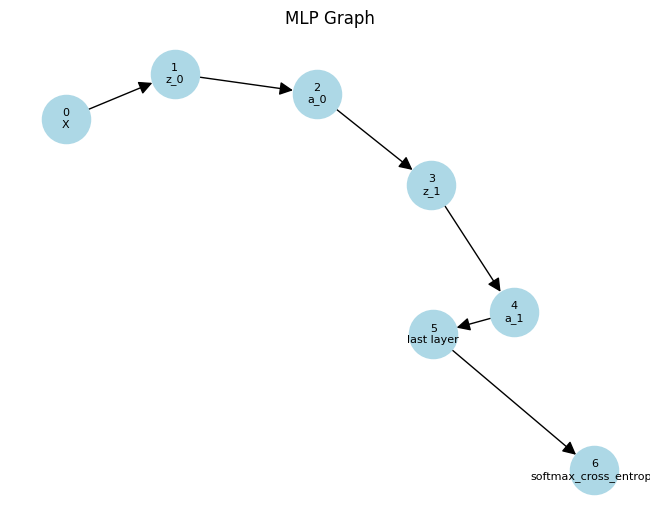

In [ ]:

def visualize_graph(mlp):
    G = mlp.graph

    labels = {
        n: f"{n}\n{G.nodes[n].get('name', '')}"
        for n in G.nodes()
    }

    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos,
        labels=labels,
        with_labels=True,
        node_color='lightblue',
        node_size=1200,
        font_size=8,
        arrows=True,
        arrowsize=20
    )

    plt.title("MLP Graph")
    plt.show()

mlp = MLP(784, [256, 256], 10, activation='relu')
mlp.build_graph()
visualize_graph(mlp)

## Experiment 1: Hidden Layers

Dataset shape: Training: (42000, 1, 28, 28), Validation: (18000, 784), Test: (10000, 784)
Flattened dataset shape: Training: (42000, 784), Validation: (18000, 784), Test: (10000, 784)
layer sizes [784, 10]
layer sizes [784, 256, 10]
layer sizes [784, 256, 256, 10]

Training No Hidden Layers...
Epoch 1/30 - Train Loss: 0.7224 - Training Accuracy: 0.7881 - Validation Accuracy: 0.7819
Epoch 2/30 - Train Loss: 0.5308 - Training Accuracy: 0.7855 - Validation Accuracy: 0.7740
Epoch 3/30 - Train Loss: 0.4951 - Training Accuracy: 0.8262 - Validation Accuracy: 0.8187
Epoch 4/30 - Train Loss: 0.4783 - Training Accuracy: 0.7660 - Validation Accuracy: 0.7603
Epoch 5/30 - Train Loss: 0.4609 - Training Accuracy: 0.7873 - Validation Accuracy: 0.7778
Epoch 6/30 - Train Loss: 0.4488 - Training Accuracy: 0.8357 - Validation Accuracy: 0.8248
Epoch 7/30 - Train Loss: 0.4412 - Training Accuracy: 0.8410 - Validation Accuracy: 0.8299
Epoch 8/30 - Train Loss: 0.4377 - Training Accuracy: 0.8320 - Validation Ac

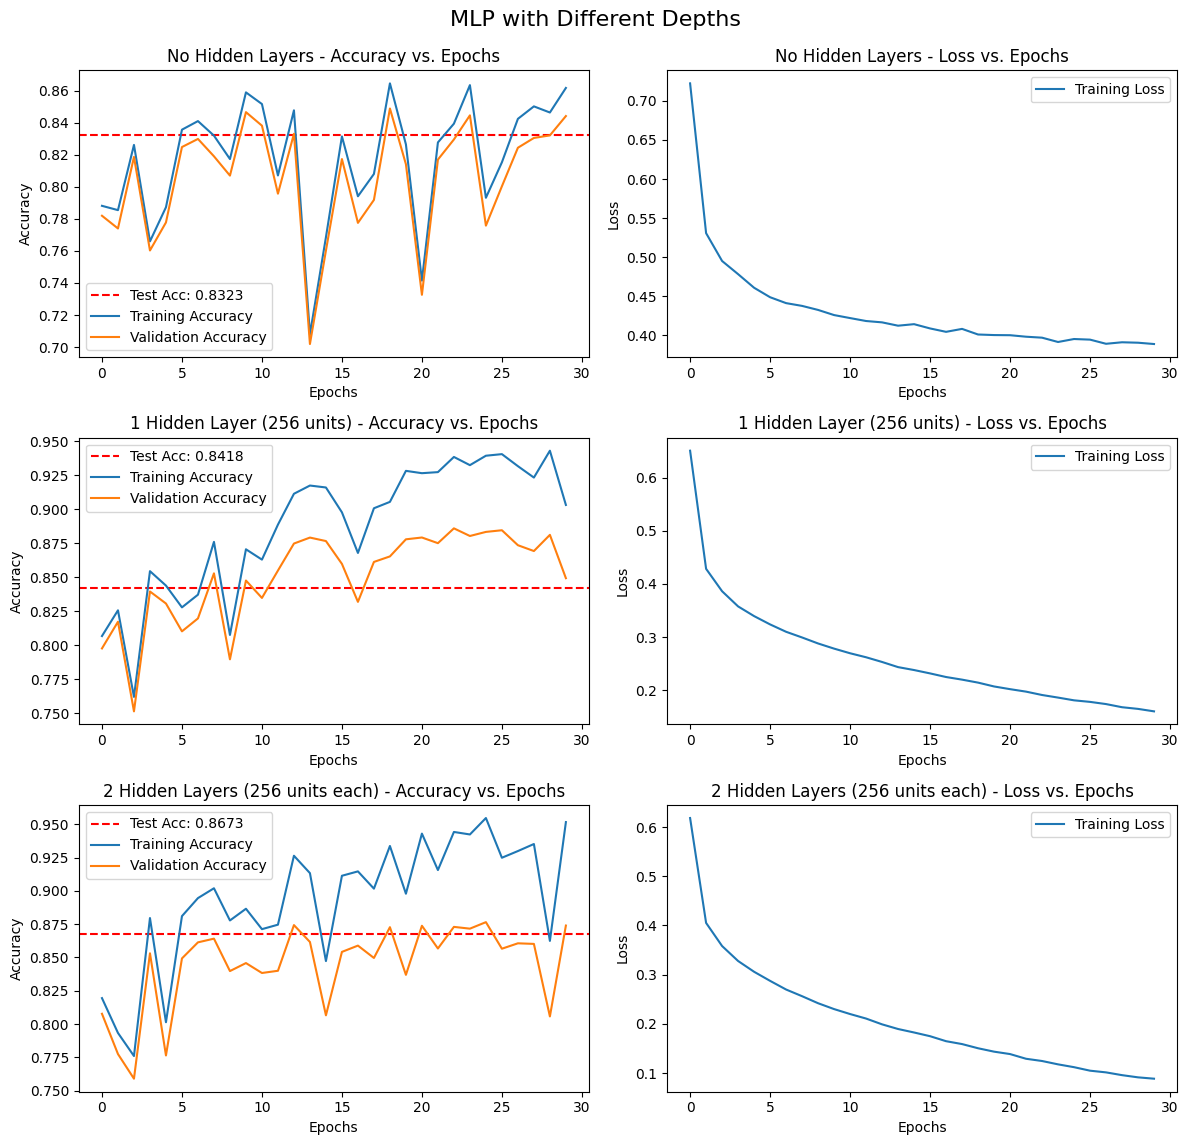

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, _, _, _ = load_fashion_mnist(data_augmentation=False)

input_size = X_train.shape[1]
output_size = 10

models = {
    'No Hidden Layers': MLP(input_size, [], output_size, activation='relu'),
    '1 Hidden Layer (256 units)': MLP(input_size, [256], output_size, activation='relu'),
    '2 Hidden Layers (256 units each)': MLP(input_size, [256, 256], output_size, activation='relu')
}

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('MLP with Different Depths', fontsize=16)
row_index = 0

for name, model in models.items():
    print(f"\nTraining {name}...")
    train_loss, train_acc, val_acc = model.fit(X_train, y_train, X_val, y_val, epochs=30, learning_rate=0.05, batch_size=128)

    ax_acc = axes[row_index, 0] # Left column: Accuracy
    ax_loss = axes[row_index, 1] # Right column: Loss

    test_acc = model.evaluate_acc(X_test, y_test)

    ax_acc.axhline(
      y=test_acc,
      color='red',
      linestyle='--',
      linewidth=1.5,
      label=f'Test Acc: {test_acc:.4f}')

    # Plot Accuracy (Left Column)
    ax_acc.plot(train_acc, label='Training Accuracy')
    ax_acc.plot(val_acc, label='Validation Accuracy')
    ax_acc.set_title(f'{name} - Accuracy vs. Epochs')
    ax_acc.set_xlabel('Epochs')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend()

    # Plot Loss (Right Column)
    ax_loss.plot(train_loss, label='Training Loss')
    #ax_loss.plot(val_loss, label='Validation Loss')
    ax_loss.set_title(f'{name} - Loss vs. Epochs')
    ax_loss.set_xlabel('Epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    print(f"{name} - Test Accuracy: {test_acc:.4f}")

    row_index += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

## Experiment 2: Activation Functions

Dataset shape: Training: (42000, 1, 28, 28), Validation: (18000, 784), Test: (10000, 784)
Flattened dataset shape: Training: (42000, 784), Validation: (18000, 784), Test: (10000, 784)
layer sizes [784, 256, 256, 10]
layer sizes [784, 256, 256, 10]

Training tanh Activation...
Epoch 1/30 - Train Loss: 0.5880 - Training Accuracy: 0.8180 - Validation Accuracy: 0.8099
Epoch 2/30 - Train Loss: 0.4229 - Training Accuracy: 0.8228 - Validation Accuracy: 0.8121
Epoch 3/30 - Train Loss: 0.3792 - Training Accuracy: 0.8530 - Validation Accuracy: 0.8353
Epoch 4/30 - Train Loss: 0.3502 - Training Accuracy: 0.8762 - Validation Accuracy: 0.8569
Epoch 5/30 - Train Loss: 0.3279 - Training Accuracy: 0.8748 - Validation Accuracy: 0.8517
Epoch 6/30 - Train Loss: 0.3087 - Training Accuracy: 0.8987 - Validation Accuracy: 0.8717
Epoch 7/30 - Train Loss: 0.2935 - Training Accuracy: 0.8927 - Validation Accuracy: 0.8607
Epoch 8/30 - Train Loss: 0.2798 - Training Accuracy: 0.8898 - Validation Accuracy: 0.8587
Epo

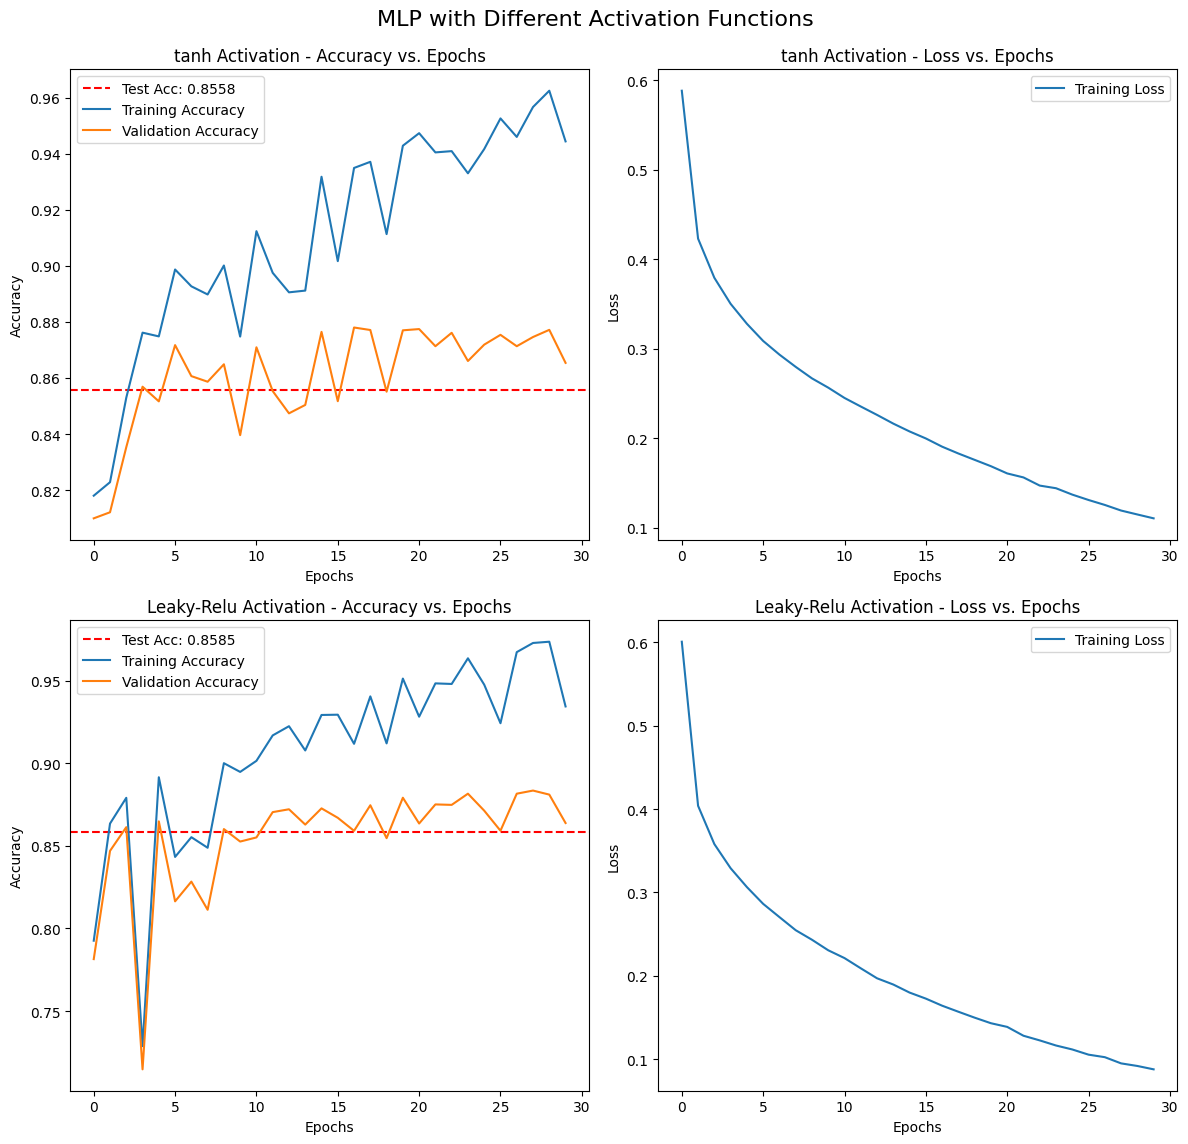

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, _, _, _ = load_fashion_mnist(data_augmentation=False)

input_size = X_train.shape[1]
output_size = 10

models = {
    'tanh Activation': MLP(input_size, [256, 256], output_size, activation='tanh'),
    'Leaky-Relu Activation': MLP(input_size, [256, 256], output_size, activation='leaky_relu')
}

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('MLP with Different Activation Functions', fontsize=16)
row_index = 0

for name, model in models.items():
    print(f"\nTraining {name}...")
    train_loss, train_acc, val_acc = model.fit(X_train, y_train, X_val, y_val, epochs=30, learning_rate=0.05, batch_size=128)

    ax_acc = axes[row_index, 0] # Left column: Accuracy
    ax_loss = axes[row_index, 1] # Right column: Loss

    test_acc = model.evaluate_acc(X_test, y_test)

    ax_acc.axhline(
      y=test_acc,
      color='red',
      linestyle='--',
      linewidth=1.5,
      label=f'Test Acc: {test_acc:.4f}')

    # Plot Accuracy (Left Column)
    ax_acc.plot(train_acc, label='Training Accuracy')
    ax_acc.plot(val_acc, label='Validation Accuracy')
    ax_acc.set_title(f'{name} - Accuracy vs. Epochs')
    ax_acc.set_xlabel('Epochs')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend()

    # Plot Loss (Right Column)
    ax_loss.plot(train_loss, label='Training Loss')
    # ax_loss.plot(val_loss, label='Validation Loss')
    ax_loss.set_title(f'{name} - Loss vs. Epochs')
    ax_loss.set_xlabel('Epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    print(f"{name} - Test Accuracy: {test_acc:.4f}")

    row_index += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

## Experiment 3: L1 & L2 Regularization

Dataset shape: Training: (42000, 1, 28, 28), Validation: (18000, 784), Test: (10000, 784)
Flattened dataset shape: Training: (42000, 784), Validation: (18000, 784), Test: (10000, 784)
layer sizes [784, 256, 256, 10]

Training L1 Regularization...
Epoch 1/30 - Train Loss: 2.7591 - Training Accuracy: 0.8323 - Validation Accuracy: 0.8226
Epoch 2/30 - Train Loss: 2.4821 - Training Accuracy: 0.7861 - Validation Accuracy: 0.7769
Epoch 3/30 - Train Loss: 2.3949 - Training Accuracy: 0.7723 - Validation Accuracy: 0.7581
Epoch 4/30 - Train Loss: 2.3290 - Training Accuracy: 0.8327 - Validation Accuracy: 0.8133
Epoch 5/30 - Train Loss: 2.2673 - Training Accuracy: 0.8063 - Validation Accuracy: 0.7914
Epoch 6/30 - Train Loss: 2.2088 - Training Accuracy: 0.8760 - Validation Accuracy: 0.8459
Epoch 7/30 - Train Loss: 2.1556 - Training Accuracy: 0.8954 - Validation Accuracy: 0.8707
Epoch 8/30 - Train Loss: 2.1079 - Training Accuracy: 0.8961 - Validation Accuracy: 0.8687
Epoch 9/30 - Train Loss: 2.0597 -

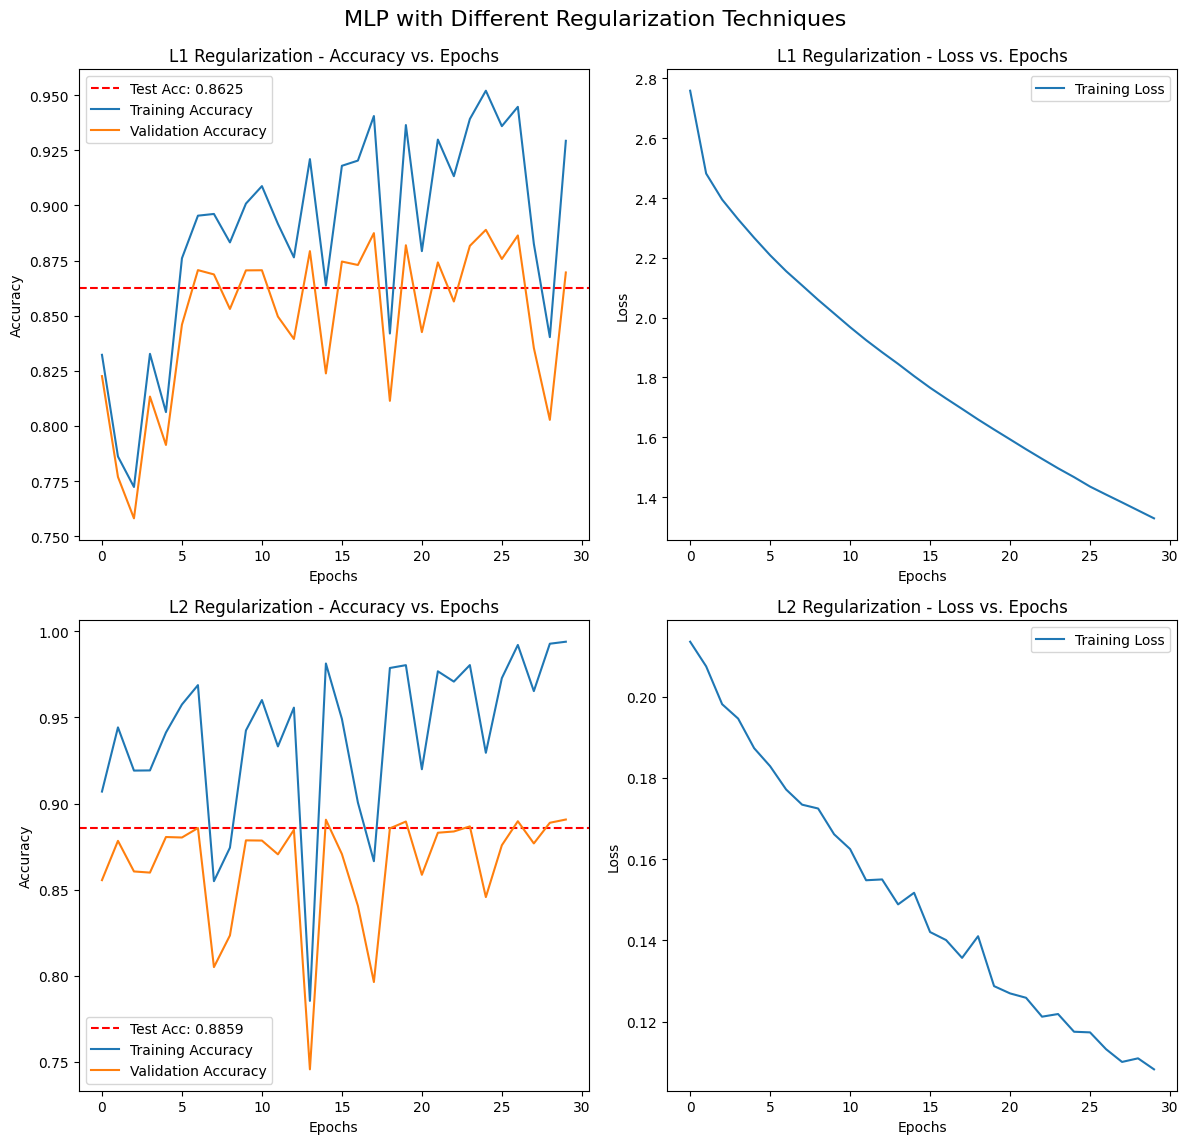

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, _, _, _ = load_fashion_mnist(data_augmentation=False)

input_size = X_train.shape[1]
output_size = 10

model = MLP(input_size, [256, 256], output_size, activation='relu')

regularizations = {
    'L1 Regularization': [0.0001, 0],
    'L2 Regularization': [0, 0.0001]
}

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('MLP with Different Regularization Techniques', fontsize=16)
row_index = 0

for name, (l1, l2) in regularizations.items():
    print(f"\nTraining {name}...")
    train_loss, train_acc, val_acc = model.fit(X_train, y_train, X_val, y_val, epochs=30, learning_rate=0.05, batch_size=128, l1_lambda=l1, l2_lambda=l2)

    ax_acc = axes[row_index, 0] # Left column: Accuracy
    ax_loss = axes[row_index, 1] # Right column: Loss

    test_acc = model.evaluate_acc(X_test, y_test)

    ax_acc.axhline(
      y=test_acc,
      color='red',
      linestyle='--',
      linewidth=1.5,
      label=f'Test Acc: {test_acc:.4f}')

    # Plot Accuracy (Left Column)
    ax_acc.plot(train_acc, label='Training Accuracy')
    ax_acc.plot(val_acc, label='Validation Accuracy')
    ax_acc.set_title(f'{name} - Accuracy vs. Epochs')
    ax_acc.set_xlabel('Epochs')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend()

    # Plot Loss (Right Column)
    ax_loss.plot(train_loss, label='Training Loss')
    # ax_loss.plot(val_loss, label='Validation Loss')
    ax_loss.set_title(f'{name} - Loss vs. Epochs')
    ax_loss.set_xlabel('Epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    print(f"{name} - Test Accuracy: {test_acc:.4f}")

    row_index += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

## Experiment 4: Unormalized Images

Dataset shape: Training: (42000, 1, 28, 28), Validation: (18000, 784), Test: (10000, 784)
Flattened dataset shape: Training: (42000, 784), Validation: (18000, 784), Test: (10000, 784)
layer sizes [784, 256, 256, 10]

Training Unormalized Images...
Epoch 1/30 - Train Loss: 0.6863 - Training Accuracy: 0.8227 - Validation Accuracy: 0.8203
Epoch 2/30 - Train Loss: 0.4804 - Training Accuracy: 0.7752 - Validation Accuracy: 0.7684
Epoch 3/30 - Train Loss: 0.4303 - Training Accuracy: 0.8277 - Validation Accuracy: 0.8217
Epoch 4/30 - Train Loss: 0.4012 - Training Accuracy: 0.8131 - Validation Accuracy: 0.8054
Epoch 5/30 - Train Loss: 0.3820 - Training Accuracy: 0.8465 - Validation Accuracy: 0.8379
Epoch 6/30 - Train Loss: 0.3647 - Training Accuracy: 0.8684 - Validation Accuracy: 0.8517
Epoch 7/30 - Train Loss: 0.3504 - Training Accuracy: 0.7909 - Validation Accuracy: 0.7757
Epoch 8/30 - Train Loss: 0.3382 - Training Accuracy: 0.8736 - Validation Accuracy: 0.8608
Epoch 9/30 - Train Loss: 0.3279 

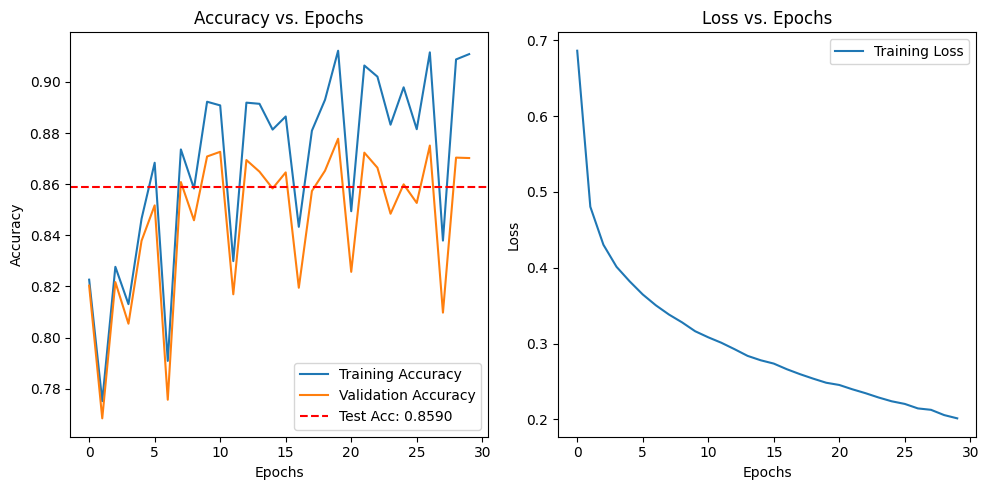

Unormalized Images - Test Accuracy: 0.8590


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, _, _, _ = load_fashion_mnist(data_augmentation=False, normalize=False)

input_size = X_train.shape[1]
output_size = 10

models = {
    'Unormalized Images': MLP(input_size, [256, 256], output_size, activation='relu')
}

results = {}

fig.suptitle('MLP with Unormalized Images', fontsize=16)

for name, model in models.items():
    print(f"\nTraining {name}...")
    train_loss, train_acc, val_acc = model.fit(X_train, y_train, X_val, y_val, epochs=30, learning_rate=0.05, batch_size=128)

    plt.figure(figsize=(10, 5))

    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    test_acc = model.evaluate_acc(X_test, y_test)

    plt.axhline(
        y=test_acc,
        color='red',
        linestyle='--',
        linewidth=1.5,
        label=f'Test Acc: {test_acc:.4f}'
    )
    plt.legend(loc='lower right')

    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    # plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"{name} - Test Accuracy: {test_acc:.4f}")



## Experiment 5: Data Augmentation

Dataset shape: Training: (84000, 1, 28, 28), Validation: (18000, 784), Test: (10000, 784)
Flattened dataset shape: Training: (84000, 784), Validation: (18000, 784), Test: (10000, 784)
layer sizes [784, 256, 256, 10]

Training L1 Regularization with Data Augmentation...
Epoch 1/30 - Train Loss: 2.8515 - Training Accuracy: 0.7816 - Validation Accuracy: 0.8267
Epoch 2/30 - Train Loss: 2.5638 - Training Accuracy: 0.8138 - Validation Accuracy: 0.8529
Epoch 3/30 - Train Loss: 2.4303 - Training Accuracy: 0.8260 - Validation Accuracy: 0.8556
Epoch 4/30 - Train Loss: 2.3209 - Training Accuracy: 0.8177 - Validation Accuracy: 0.8501
Epoch 5/30 - Train Loss: 2.2223 - Training Accuracy: 0.8390 - Validation Accuracy: 0.8647
Epoch 6/30 - Train Loss: 2.1305 - Training Accuracy: 0.8421 - Validation Accuracy: 0.8619
Epoch 7/30 - Train Loss: 2.0447 - Training Accuracy: 0.8396 - Validation Accuracy: 0.8574
Epoch 8/30 - Train Loss: 1.9637 - Training Accuracy: 0.8648 - Validation Accuracy: 0.8736
Epoch 9/30

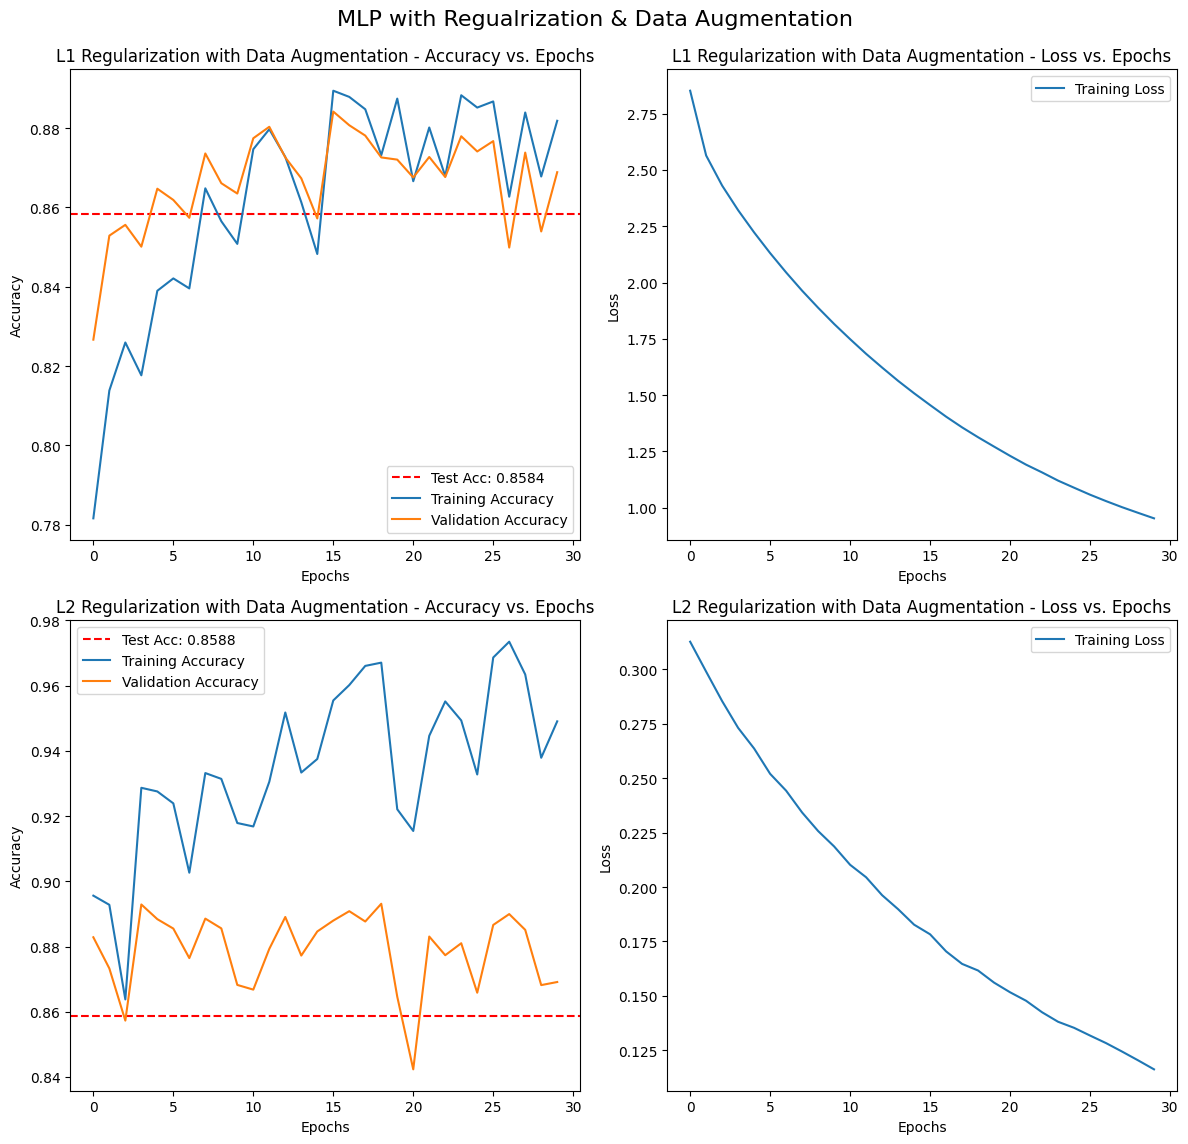

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, _, _, _ = load_fashion_mnist(data_augmentation=True)

input_size = X_train.shape[1]
output_size = 10

model = MLP(input_size, [256, 256], output_size, activation='relu')

regularizations = {
    'L1 Regularization with Data Augmentation': [0.0001, 0],
    'L2 Regularization with Data Augmentation': [0, 0.0001]
}

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('MLP with Regualrization & Data Augmentation', fontsize=16)
row_index = 0

for name, (l1, l2) in regularizations.items():
    print(f"\nTraining {name}...")
    train_loss, train_acc, val_acc = model.fit(X_train, y_train, X_val, y_val, epochs=30, learning_rate=0.05, batch_size=128, l1_lambda=l1, l2_lambda=l2)

    ax_acc = axes[row_index, 0] # Left column: Accuracy
    ax_loss = axes[row_index, 1] # Right column: Loss

    test_acc = model.evaluate_acc(X_test, y_test)

    ax_acc.axhline(
      y=test_acc,
      color='red',
      linestyle='--',
      linewidth=1.5,
      label=f'Test Acc: {test_acc:.4f}')

    # Plot Accuracy (Left Column)
    ax_acc.plot(train_acc, label='Training Accuracy')
    ax_acc.plot(val_acc, label='Validation Accuracy')
    ax_acc.set_title(f'{name} - Accuracy vs. Epochs')
    ax_acc.set_xlabel('Epochs')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend()

    # Plot Loss (Right Column)
    ax_loss.plot(train_loss, label='Training Loss')
    # ax_loss.plot(val_loss, label='Validation Loss')
    ax_loss.set_title(f'{name} - Loss vs. Epochs')
    ax_loss.set_xlabel('Epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    print(f"{name} - Test Accuracy: {test_acc:.4f}")

    row_index += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

#Experiment 6: Convolutional Neural Network

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision import models
import torch.nn.functional as F

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
from scipy.spatial import transform
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Dataset should have PIL images of range [0,1].
#ToTensor transforms them to Tensors of normalized range [0,1], and using Normalize*((0.5),(0.5))
#Maps that range to a range of [-1,1] with mean and std of 0.5

CNN_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) #Grayscale=one channel, so one value in each array
])
def load_fashion_mnist_conv(base_transform = CNN_transform):
    # Load the Fashion MNIST dataset
    train_dataset_conv = datasets.FashionMNIST(root='./data', train=True, download=True,
                                          transform = base_transform)

    test_dataset_conv = datasets.FashionMNIST(root='./data', train=False, download=True,
                                        transform = base_transform)

    # Split into 70/30 split for training and validation
    train_size = int(0.7 * len(train_dataset_conv))
    val_size = len(train_dataset_conv) - train_size
    train_dataset_conv, val_dataset_conv = random_split(train_dataset_conv, [train_size, val_size])


    return train_dataset_conv, val_dataset_conv, test_dataset_conv



In [ ]:
#define model architectrure (number of channels can be modified)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding = 1) #(#input channel, #output channels, kernel_size)
        self.pool = nn.MaxPool2d(2, 2) #(kernel size, stride)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1) #input channel size must be equal to last layes's output channel size)

        # 28x28 -> conv -> pool -> 14x14
        # 14x14 -> conv -> pool -> 7x7
        self.fc1 = nn.Linear(16*7*7, 256) #( 16 input channels*number of pixels after those convolutional layers interspliced with pooling layers
                                          #, output size/#hidden nodes)
        self.fc2 = nn.Linear(256, 10) #(input size, output size = number of classes bc this is the outpue layer)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*7*7) #-1 pytorch determines the correct sizes for us, i.e number of batches
        x = F.relu(self.fc1(x))
        x = self.fc2(x) #No softmax activation function because this is already included in the CrossEntropyLoss criterion
        return x

In [ ]:
#Conceptually evaluate_model comes after train_CNN, but since I want to use
#this function to draw graphs of accuracy wrt epochs, I'm worried the function definition
#may work weird with the notebook
def evaluate_model(model, test_loader, device, class_specific = False):
  with torch.no_grad():
      n_correct = 0
      n_samples = 0
      if class_specific:
          n_class_correct = [0 for i in range(10)]
          n_class_samples = [0 for i in range(10)]
      else:
          n_class_correct = None #Honestly it hurts my eyes but I ain't morally
          n_class_samples = None #pure either

      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          # max returns (value, index)
          _, predicted = torch.max(outputs, 1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()

          if class_specific:
              for i in range(labels.size(0)): #Find size of the batch, which can be simply batch_size or leftover
                  label = labels[i]
                  pred = predicted[i]
                  if (label == pred):
                      n_class_correct[label] += 1
                  n_class_samples[label] += 1

      return n_correct, n_samples, n_class_correct, n_class_samples

def train_CNN(train_loader, val_loader, num_epochs, learning_rate, device, VERBOSE=True):

  model = ConvNet().to(device)

  epoch_loss = np.zeros(num_epochs)
  epoch_train_accuracy = np.zeros(num_epochs)
  epoch_val_accuracy = np.zeros(num_epochs)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  n_total_steps = len(train_loader)
  for epoch in range(num_epochs):

      #batch_loss = np.zeros(len(train_loader.dataset)) #record each batch loss for avg
      batch_loss = np.zeros(n_total_steps)

      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)
          #Shape of origin: [# batches, # input channels, #pixels, #pixels]
          #e.g. [4, 3, 28, 28]
          #input layer to the fully connected mlp: 3 input channels (if it were RGB), 6 output channels , 3 or 5 kernel size

          #Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          batch_loss[i] = loss.item()

          #Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          #Say we want 8 updates per epoch, so n_total_steps//8
          if (i+1) % (n_total_steps//8) == 0 and VERBOSE:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

      n_correct, n_samples, _, _ = evaluate_model(model, train_loader, device)
      epoch_train_accuracy[epoch] =  100 * n_correct / n_samples

      val_n_correct, val_n_samples, _, _ = evaluate_model(model, val_loader, device)
      epoch_val_accuracy[epoch] = 100 * val_n_correct / val_n_samples

      epoch_loss[epoch] = np.mean(batch_loss)

      if VERBOSE:
        print(f'----------Epoch [{epoch+1}/{num_epochs}] Avg. Batch Loss : {loss.item():.4f}-----------')
  if VERBOSE:
    print('Finished Training')
  return model, epoch_loss, epoch_train_accuracy, epoch_val_accuracy


def test_CNN(model, test_loader, device):
  n_correct, n_samples, _, _ = evaluate_model(model, test_loader, device)
  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')
  return acc

In [ ]:
train_dataset_conv, val_dataset_conv, test_dataset_conv = load_fashion_mnist_conv()

Epoch [1/4], Step [1312/10500], Loss: 0.0931
Epoch [1/4], Step [2624/10500], Loss: 0.3579
Epoch [1/4], Step [3936/10500], Loss: 0.3783
Epoch [1/4], Step [5248/10500], Loss: 0.3143
Epoch [1/4], Step [6560/10500], Loss: 1.0007
Epoch [1/4], Step [7872/10500], Loss: 0.5262
Epoch [1/4], Step [9184/10500], Loss: 0.0103
Epoch [1/4], Step [10496/10500], Loss: 0.5646
----------Epoch [1/4] Avg. Batch Loss : 0.2572-----------
Epoch [2/4], Step [1312/10500], Loss: 0.1280
Epoch [2/4], Step [2624/10500], Loss: 0.9854
Epoch [2/4], Step [3936/10500], Loss: 0.1121
Epoch [2/4], Step [5248/10500], Loss: 0.3233
Epoch [2/4], Step [6560/10500], Loss: 0.2828
Epoch [2/4], Step [7872/10500], Loss: 0.0385
Epoch [2/4], Step [9184/10500], Loss: 0.6339
Epoch [2/4], Step [10496/10500], Loss: 0.2317
----------Epoch [2/4] Avg. Batch Loss : 0.1716-----------
Epoch [3/4], Step [1312/10500], Loss: 0.5963
Epoch [3/4], Step [2624/10500], Loss: 0.1561
Epoch [3/4], Step [3936/10500], Loss: 1.1888
Epoch [3/4], Step [5248/105

NameError: name 'ax_acc' is not defined

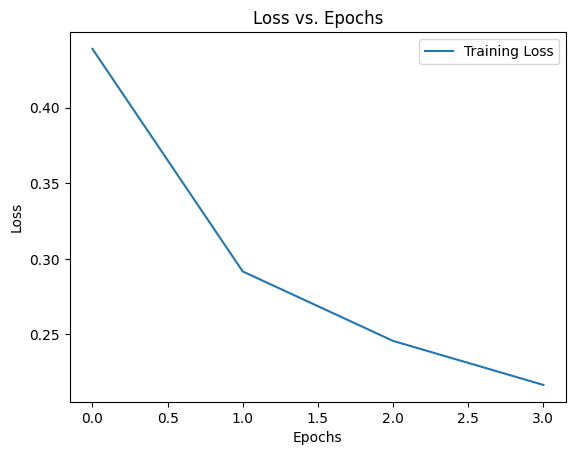

In [ ]:
#Hyper parameters
num_epochs = 4
batch_size = 4
learning_rate = 0.001


train_loader = DataLoader(train_dataset_conv, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_conv, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_conv, batch_size=batch_size, shuffle=False)


model, epoch_loss, train_accuracy, val_accuracy = train_CNN(train_loader, val_loader, num_epochs, learning_rate, device)


#trained and ran in 7 min 52s on the Colab resources

Accuracy of the network: 89.56 %


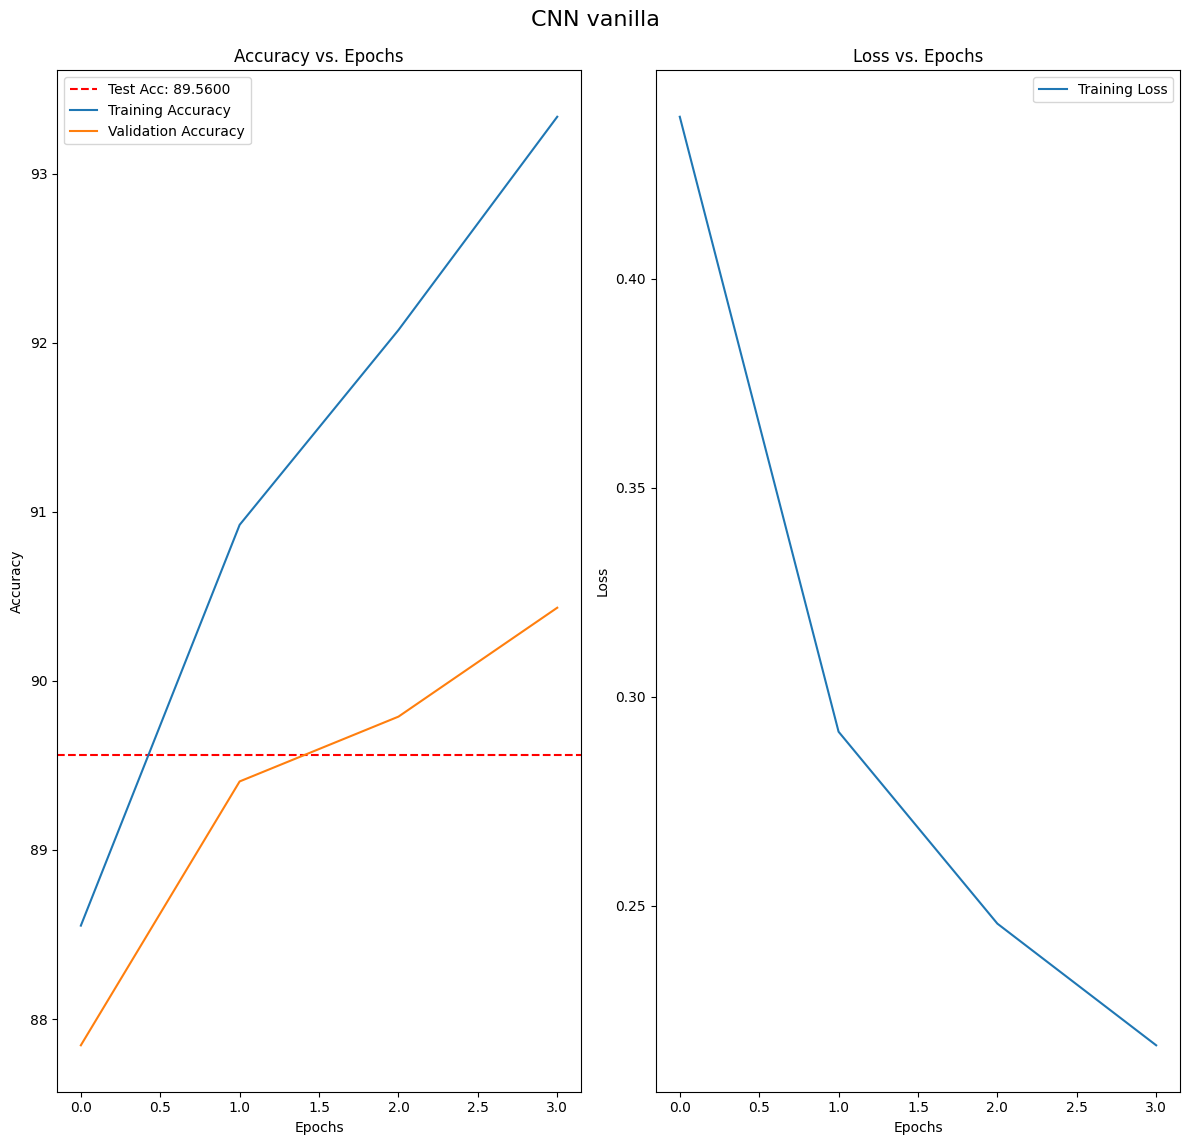

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
fig.suptitle('CNN vanilla', fontsize=16)

ax_acc = axes[0] # Left column: Accuracy
ax_loss = axes[1] # Right column: Loss

test_acc = test_CNN(model, test_loader, device)

ax_acc.axhline(
  y=test_acc,
  color='red',
  linestyle='--',
  linewidth=1.5,
  label=f'Test Acc: {test_acc:.4f}')

#Loss plot
ax_loss.plot(epoch_loss, label='Training Loss')
ax_loss.set_title('Loss vs. Epochs')
ax_loss.set_xlabel('Epochs')
ax_loss.set_ylabel('Loss')
ax_loss.legend()

# Plot Accuracy (Left Column)
ax_acc.plot(train_accuracy, label='Training Accuracy')
ax_acc.plot(val_accuracy, label='Validation Accuracy')
ax_acc.set_title(f'Accuracy vs. Epochs')
ax_acc.set_xlabel('Epochs')
ax_acc.set_ylabel('Accuracy')
ax_acc.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

In [ ]:
test_CNN(model, test_loader, device)

Accuracy of the network: 89.56 %


89.56

## Performance when using the same hyperparameters as Exp 1

In [ ]:
#Hyper parameters epochs=30, learning_rate=0.01, batch_size=128
num_epochs = 30
batch_size = 128
learning_rate = 0.01

#Initialize the loaders
train_loader = DataLoader(train_dataset_conv, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_conv, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_conv, batch_size=batch_size, shuffle=False)

#Train and test the models
model, epoch_loss, epoch_train_accuracy, epoch_val_accuracy = train_CNN(train_loader, val_loader, num_epochs, learning_rate, device)


Epoch [1/30], Step [41/329], Loss: 0.6858
Epoch [1/30], Step [82/329], Loss: 0.6489
Epoch [1/30], Step [123/329], Loss: 0.4634
Epoch [1/30], Step [164/329], Loss: 0.4370
Epoch [1/30], Step [205/329], Loss: 0.4547
Epoch [1/30], Step [246/329], Loss: 0.2893
Epoch [1/30], Step [287/329], Loss: 0.3778
Epoch [1/30], Step [328/329], Loss: 0.5719
----------Epoch [1/30] Avg. Batch Loss : 0.8741-----------
Epoch [2/30], Step [41/329], Loss: 0.3342
Epoch [2/30], Step [82/329], Loss: 0.3329
Epoch [2/30], Step [123/329], Loss: 0.4144
Epoch [2/30], Step [164/329], Loss: 0.3852
Epoch [2/30], Step [205/329], Loss: 0.2915
Epoch [2/30], Step [246/329], Loss: 0.3076
Epoch [2/30], Step [287/329], Loss: 0.4560
Epoch [2/30], Step [328/329], Loss: 0.2917
----------Epoch [2/30] Avg. Batch Loss : 0.5919-----------
Epoch [3/30], Step [41/329], Loss: 0.2369
Epoch [3/30], Step [82/329], Loss: 0.1989
Epoch [3/30], Step [123/329], Loss: 0.2467
Epoch [3/30], Step [164/329], Loss: 0.2613
Epoch [3/30], Step [205/329]

In [ ]:
#test the models
test_CNN(model, test_loader, device)

Accuracy of the network: 88.2 %


88.2

Accuracy of the network: 88.2 %


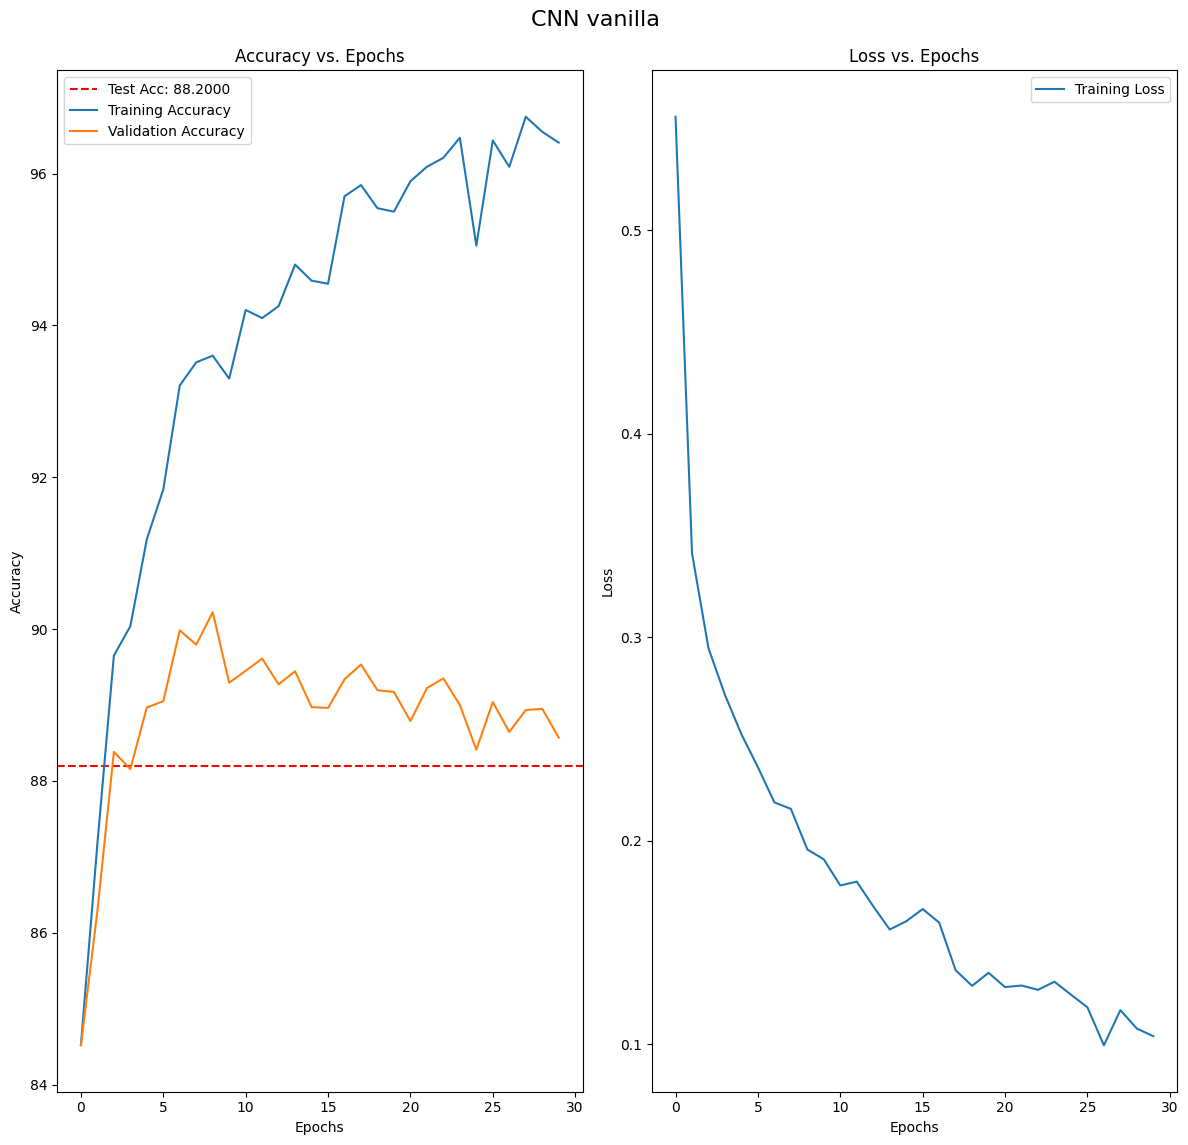

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
fig.suptitle('CNN vanilla', fontsize=16)

ax_acc = axes[0] # Left column: Accuracy
ax_loss = axes[1] # Right column: Loss

test_acc = test_CNN(model, test_loader, device)

ax_acc.axhline(
  y=test_acc,
  color='red',
  linestyle='--',
  linewidth=1.5,
  label=f'Test Acc: {test_acc:.4f}')

#Loss plot
ax_loss.plot(epoch_loss, label='Training Loss')
ax_loss.set_title('Loss vs. Epochs')
ax_loss.set_xlabel('Epochs')
ax_loss.set_ylabel('Loss')
ax_loss.legend()

# Plot Accuracy (Left Column)
ax_acc.plot(epoch_train_accuracy, label='Training Accuracy')
ax_acc.plot(epoch_val_accuracy, label='Validation Accuracy')
ax_acc.set_title(f'Accuracy vs. Epochs')
ax_acc.set_xlabel('Epochs')
ax_acc.set_ylabel('Accuracy')
ax_acc.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

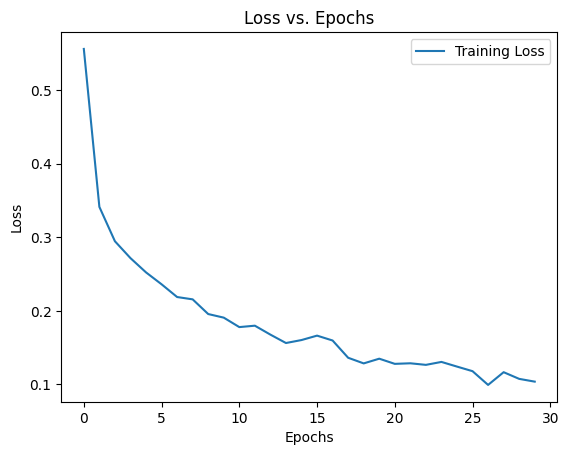

In [ ]:
#Loss plot
plt.plot(epoch_loss, label='Training Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#Experiment 7 CNN using data augmentation

In [ ]:
#Choose similar hyperparameters as exp 5
num_epochs = 30
batch_size = 128
learning_rate = 0.01

#Define the transforms for Data augmentation
augment_transform = transforms.Compose([transforms.RandomRotation(10),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5), (0.5)) #Check your understanding of what this does
                                        ])
#Redefine transform for regular pictures
CNN_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) #Grayscale=one channel, so one value in each array
])

#Load the datasets
train_dataset_augm = datasets.FashionMNIST(root='./data', train=True, download=True,
                                      transform = augment_transform)

test_dataset_augm = datasets.FashionMNIST(root='./data', train=False, download=True,
                                     transform = augment_transform)
#Initialize the loaders
train_loader_augm = DataLoader(train_dataset_augm, batch_size=batch_size, shuffle=True)
val_loader_augm = DataLoader(val_dataset_conv, batch_size=batch_size, shuffle=False)
test_loader_augm = DataLoader(test_dataset_augm, batch_size=batch_size, shuffle=False)

# #set up the transform for DataAugmentation
# # Applies one of these augmentation methods
# augment_transform = transforms.Compose([transforms.RandomRotation(10),
#                                         transforms.RandomHorizontalFlip(),
#                                         transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#                                         transforms.ToTensor()])

# augmented_images = []

# for img in X_train:
#     # Convert to PIL to apply the augmentation
#     img_pil = transforms.ToPILImage()(img)
#     img_aug = augment_transform(img_pil)
#     augmented_images.append(img_aug)

#         # Concatenate original and augmented data
#         X_train = torch.cat([X_train, torch.stack(augmented_images)])
#         y_train = torch.cat([y_train, y_train]) # Duplicate labels since each X_train has been augmented once

#Train and test the models
model, epoch_loss, train_accuracy, val_accuracy = train_CNN(train_loader_augm, num_epochs, learning_rate, device)
test_CNN(model, test_loader_augm, device)

#Loss plot
plt.plot(epoch_loss, label='Training Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]


KeyboardInterrupt: 

## Redo experiment
But with both augmented and non-augmented images datasets
and the hyperparameters found in grid search

In [ ]:
#Choose similar hyperparameters as final parameter space of exp 6
num_epochs = 15 #15 for mimi server
batch_size = 128
learning_rate = 0.005

#Define the transforms for Data augmentation
augment_transform = transforms.Compose([transforms.RandomRotation(10),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5), (0.5)) #Check your understanding of what this does
                                        ])
#Redefine transform for regular pictures
CNN_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) #Grayscale=one channel, so one value in each array
])

#load both datasets
train_dataset_conv, val_dataset_conv, test_dataset_conv = load_fashion_mnist_conv(base_transform = CNN_transform)
train_dataset_augm, val_dataset_augm, test_dataset_augm = load_fashion_mnist_conv(base_transform = augment_transform)

#concatenate the training datasets
full_train_dataset_conv = torch.utils.data.ConcatDataset([train_dataset_conv, train_dataset_augm])
#full_val_dataset_conv =torch.utils.data.ConcatDataset([val_dataset_conv, val_dataset_augm])
#full_test_dataset_conv = torch.utils.data.ConcatDataset([test_dataset_conv, test_dataset_augm])

#Design decision, I do want to use the full training dataset, but does it really
#make sense to draw conclusions from a validation set that has been partly concatenated?
#I suppose it does not because I want to have a broader training dataset to try to
#classify the same validation set as the previous task, if I really want to compare apples
#with apples.

#Initialize the loaders
full_train_loader = DataLoader(full_train_dataset_conv, batch_size=batch_size, shuffle=True)
val_loader_conv = DataLoader(val_dataset_conv, batch_size=batch_size, shuffle=False)
test_loader_conv = DataLoader(test_dataset_augm, batch_size=batch_size, shuffle=False)



Redefine architecture to fit multiple different architectural parameters

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, channels_1=6, channels_2=16, kernel_size=3, padding=1, stride=1):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels_1, kernel_size=kernel_size, padding=padding, stride=stride)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(channels_1, channels_2, kernel_size=kernel_size, padding=padding, stride=stride)

#Calculate the size after convolutions and pooling
#Input: 28x28
# After conv1: depends on kernel_size, padding, stride
# After pool1: divided by 2
# After conv2: depends on kernel_size, padding, stride
# After pool2: divided by 2
#General formula: output_size = (input_size + 2*padding - kernel_size) / stride + 1
        size_after_conv1 = (28 + 2*padding - kernel_size) // stride + 1
        size_after_pool1 = size_after_conv1 // 2
        size_after_conv2 = (size_after_pool1 + 2*padding - kernel_size) // stride + 1
        size_after_pool2 = size_after_conv2 // 2

        self.fc_input_size = channels_2 * size_after_pool2 * size_after_pool2

        self.fc1 = nn.Linear(self.fc_input_size, 256)
        self.fc2 = nn.Linear(256, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc_input_size) #-1 pytorch determines the correct sizes for us, i.e number of batches
        x = F.relu(self.fc1(x))
        x = self.fc2(x) #No softmax activation function because this is already included in the CrossEntropyLoss criterion
        return x

In [ ]:
#Conceptually evaluate_model comes after train_CNN, but since I want to use
#this function to draw graphs of accuracy wrt epochs, I'm worried the function definition
#may work weird with the notebook
def evaluate_model(model, test_loader, device, class_specific = False):
  with torch.no_grad():
      n_correct = 0
      n_samples = 0
      if class_specific:
          n_class_correct = [0 for i in range(10)]
          n_class_samples = [0 for i in range(10)]
      else:
          n_class_correct = None #Honestly it hurts my eyes but I ain't morally
          n_class_samples = None #pure either

      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          # max returns (value, index)
          _, predicted = torch.max(outputs, 1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()

          if class_specific:
              for i in range(labels.size(0)): #Find size of the batch, which can be simply batch_size or leftover
                  label = labels[i]
                  pred = predicted[i]
                  if (label == pred):
                      n_class_correct[label] += 1
                  n_class_samples[label] += 1

      return n_correct, n_samples, n_class_correct, n_class_samples

def train_CNN(train_loader, val_loader, num_epochs, learning_rate, architecural_param, device, VERBOSE=True):
  channels_1, channels_2, kernel_size, padding, stride = architecural_param
  model = ConvNet(channels_1, channels_2, kernel_size, padding, stride).to(device)

  epoch_loss = np.zeros(num_epochs)
  epoch_train_accuracy = np.zeros(num_epochs)
  epoch_val_accuracy = np.zeros(num_epochs)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  n_total_steps = len(train_loader)
  for epoch in range(num_epochs):

      #batch_loss = np.zeros(len(train_loader.dataset)) #record each batch loss for avg
      batch_loss = np.zeros(n_total_steps)

      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)
          #Shape of origin: [# batches, # input channels, #pixels, #pixels]
          #e.g. [4, 3, 28, 28]
          #input layer to the fully connected mlp: 3 input channels (if it were RGB), 6 output channels , 3 or 5 kernel size

          #Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          batch_loss[i] = loss.item()

          #Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          #Say we want 8 updates per epoch, so n_total_steps//8
          if (i+1) % (n_total_steps//8) == 0 and VERBOSE:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

      n_correct, n_samples, _, _ = evaluate_model(model, train_loader, device)
      epoch_train_accuracy[epoch] =  100 * n_correct / n_samples

      val_n_correct, val_n_samples, _, _ = evaluate_model(model, val_loader, device)
      epoch_val_accuracy[epoch] = 100 * val_n_correct / val_n_samples

      epoch_loss[epoch] = np.mean(batch_loss)

      if VERBOSE:
        print(f'----------Epoch [{epoch+1}/{num_epochs}] Avg. Batch Loss : {loss.item():.4f}-----------')
  if VERBOSE:
    print('Finished Training')
  return model, epoch_loss, epoch_train_accuracy, epoch_val_accuracy


def test_CNN(model, test_loader, device):
  n_correct, n_samples, _, _ = evaluate_model(model, test_loader, device)
  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')
  return acc

In [ ]:
#Architectural parameters
channels_1=16
channels_2=32
kernel_size=3
padding=1
stride=1

architecural_param = (channels_1, channels_2, kernel_size, padding, stride)

#Train model

from timeit import default_timer as timer

start = timer()

model, epoch_loss, epoch_train_accuracy, epoch_val_accuracy = train_CNN(full_train_loader, val_loader_conv, num_epochs, learning_rate, architecural_param, device)

end = timer()

#training_time = end - start
print(f"Training time: {end - start:.2f}s")

Epoch [1/15], Step [82/657], Loss: 0.6175
Epoch [1/15], Step [164/657], Loss: 0.5263
Epoch [1/15], Step [246/657], Loss: 0.6101
Epoch [1/15], Step [328/657], Loss: 0.4806
Epoch [1/15], Step [410/657], Loss: 0.3216
Epoch [1/15], Step [492/657], Loss: 0.4052
Epoch [1/15], Step [574/657], Loss: 0.3950
Epoch [1/15], Step [656/657], Loss: 0.5490
----------Epoch [1/15] Avg. Batch Loss : 0.5807-----------
Epoch [2/15], Step [82/657], Loss: 0.4310
Epoch [2/15], Step [164/657], Loss: 0.3458
Epoch [2/15], Step [246/657], Loss: 0.3424
Epoch [2/15], Step [328/657], Loss: 0.4401
Epoch [2/15], Step [410/657], Loss: 0.1967
Epoch [2/15], Step [492/657], Loss: 0.2629
Epoch [2/15], Step [574/657], Loss: 0.4186
Epoch [2/15], Step [656/657], Loss: 0.3855
----------Epoch [2/15] Avg. Batch Loss : 0.3870-----------
Epoch [3/15], Step [82/657], Loss: 0.2062
Epoch [3/15], Step [164/657], Loss: 0.2457
Epoch [3/15], Step [246/657], Loss: 0.3266
Epoch [3/15], Step [328/657], Loss: 0.2516
Epoch [3/15], Step [410/6

Accuracy of the network: 87.3 %


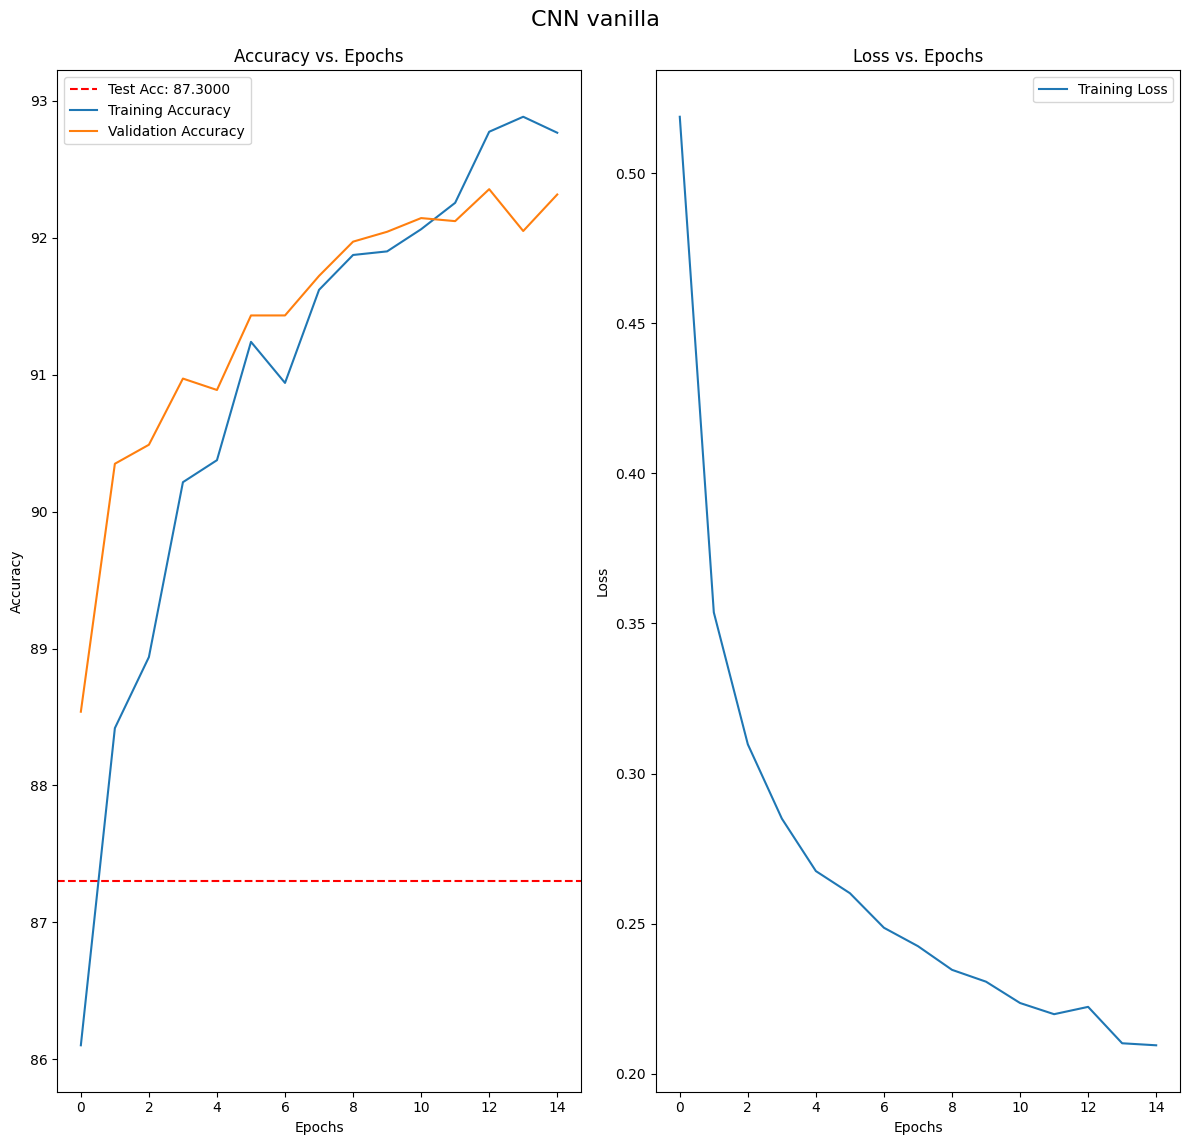

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
fig.suptitle('CNN vanilla', fontsize=16)

ax_acc = axes[0] # Left column: Accuracy
ax_loss = axes[1] # Right column: Loss

test_acc = test_CNN(model, test_loader_conv, device)

ax_acc.axhline(
  y=test_acc,
  color='red',
  linestyle='--',
  linewidth=1.5,
  label=f'Test Acc: {test_acc:.4f}')

#Loss plot
ax_loss.plot(epoch_loss, label='Training Loss')
ax_loss.set_title('Loss vs. Epochs')
ax_loss.set_xlabel('Epochs')
ax_loss.set_ylabel('Loss')
ax_loss.legend()

# Plot Accuracy (Left Column)
ax_acc.plot(epoch_train_accuracy, label='Training Accuracy')
ax_acc.plot(epoch_val_accuracy, label='Validation Accuracy')
ax_acc.set_title(f'Accuracy vs. Epochs')
ax_acc.set_xlabel('Epochs')
ax_acc.set_ylabel('Accuracy')
ax_acc.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

#Experiment 8: Using a pre-trained convolutional network

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
#check out tutorial at: https://www.youtube.com/watch?v=Ky3R0gxFUbo
# Load a pre-trained ResNet18 model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the final MLP classification layers through experimenting
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)


# Creativity: Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the Fashion MNIST dataset
X_train, y_train, X_val, y_val, X_test, y_test, _, _, _ = load_fashion_mnist(data_augmentation=False)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

input_size = X_train.shape[1]
output_size = 10

model = MLP(input_size, [256, 256], output_size, activation='relu')
train_loss, val_loss, train_acc, val_acc = model.fit(X_train, y_train, X_val, y_val, epochs=30, learning_rate=0.05, batch_size=128)

preds = model.predict(X_test)
targets = y_test

# Confusion matrix
plt.figure(figsize = (8,8))
cm = confusion_matrix(targets, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.xticks(np.arange(10) + 0.5, class_names, rotation=45)
plt.yticks(np.arange(10) + 0.5, class_names, rotation= 45)
plt.ylabel('True label')
plt.title("Confusion Matrix of FashionMNIST Dataset")
plt.show()


# Creativity: Effect of Width on MLP

Dataset shape: Training: (42000, 1, 28, 28), Validation: (18000, 784), Test: (10000, 784)
Flattened dataset shape: Training: (42000, 784), Validation: (18000, 784), Test: (10000, 784)
layer sizes [784, 16, 10]
layer sizes [784, 32, 10]
layer sizes [784, 64, 10]
layer sizes [784, 128, 10]
layer sizes [784, 256, 10]
layer sizes [784, 512, 10]
layer sizes [784, 1024, 10]
layer sizes [784, 2048, 10]
layer sizes [784, 4096, 10]

Training 1 Hidden Layer (16 units)...
Epoch 1/20 - Train Loss: 1.0808 - Training Accuracy: 0.7557 - Validation Accuracy: 0.7515
Epoch 2/20 - Train Loss: 0.6473 - Training Accuracy: 0.8000 - Validation Accuracy: 0.7974
Epoch 3/20 - Train Loss: 0.5510 - Training Accuracy: 0.7910 - Validation Accuracy: 0.7832
Epoch 4/20 - Train Loss: 0.5030 - Training Accuracy: 0.8294 - Validation Accuracy: 0.8197
Epoch 5/20 - Train Loss: 0.4737 - Training Accuracy: 0.8250 - Validation Accuracy: 0.8167
Epoch 6/20 - Train Loss: 0.4528 - Training Accuracy: 0.8278 - Validation Accuracy: 0

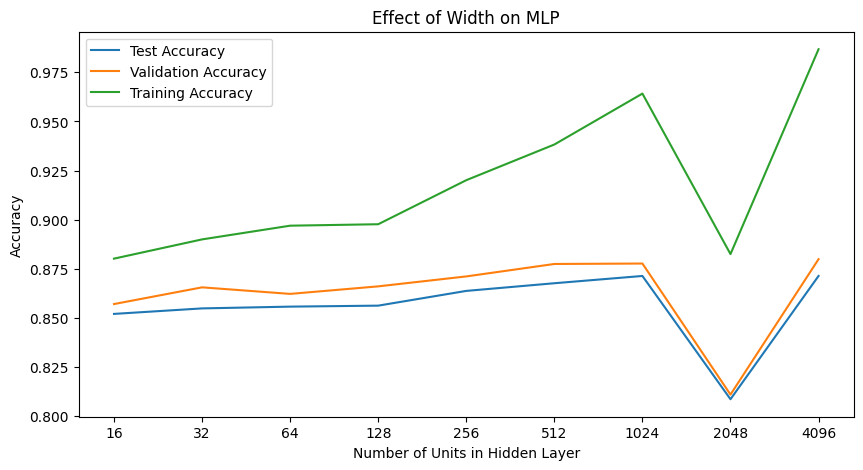

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, _, _, _ = load_fashion_mnist(data_augmentation=False)

input_size = X_train.shape[1]
output_size = 10

models = {
    '1 Hidden Layer (16 units)': MLP(input_size, [16], output_size, activation='tanh'),
    '1 Hidden Layer (32 units)': MLP(input_size, [32], output_size, activation='tanh'),
    '1 Hidden Layer (64 units)': MLP(input_size, [64], output_size, activation='tanh'),
    '1 Hidden Layer (128 units)': MLP(input_size, [128], output_size, activation='tanh'),
    '1 Hidden Layer (256 units)': MLP(input_size, [256], output_size, activation='tanh'),
    '1 Hidden Layer (512 units)': MLP(input_size, [512], output_size, activation='tanh'),
    '1 Hidden Layer (1024 units)': MLP(input_size, [1024], output_size, activation='tanh'),
    '1 Hidden Layer (2048 units)': MLP(input_size, [2048], output_size, activation='tanh'),
    '1 Hidden Layer (4096 units)': MLP(input_size, [4096], output_size, activation='tanh'),
}

units = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
train_acc_per_unit = []
val_acc_per_unit = []
test_acc_per_unit = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    train_loss, train_acc, val_acc = model.fit(X_train, y_train, X_val, y_val, epochs=20, learning_rate=0.05, batch_size=128)

    test_acc = model.evaluate_acc(X_test, y_test)

    train_acc_per_unit.append(train_acc[-1])
    val_acc_per_unit.append(val_acc[-1])
    test_acc_per_unit.append(test_acc)

    print(f"{name} - Test Accuracy: {test_acc:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(units, test_acc_per_unit, label='Test Accuracy')
plt.plot(units, val_acc_per_unit, label='Validation Accuracy')
plt.plot(units, train_acc_per_unit, label='Training Accuracy')
plt.xscale('log', base=2)
plt.xticks(units, units)
plt.xlabel('Number of Units in Hidden Layer')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Effect of Width on MLP')
plt.show()


# Creativity: Early Stopping

Dataset shape: Training: (42000, 1, 28, 28), Validation: (18000, 784), Test: (10000, 784)
Flattened dataset shape: Training: (42000, 784), Validation: (18000, 784), Test: (10000, 784)
layer sizes [784, 256, 10]

Training Early Stopping...
Epoch 1/30 - Train Loss: 0.8209 - Val Loss: 0.6178 - Training Accuracy: 0.7914 - Validation Accuracy: 0.7896
Epoch 2/30 - Train Loss: 0.5453 - Val Loss: 0.5280 - Training Accuracy: 0.8222 - Validation Accuracy: 0.8137
Epoch 3/30 - Train Loss: 0.4903 - Val Loss: 0.5113 - Training Accuracy: 0.8313 - Validation Accuracy: 0.8207
Epoch 4/30 - Train Loss: 0.4578 - Val Loss: 0.4772 - Training Accuracy: 0.8415 - Validation Accuracy: 0.8304
Epoch 5/30 - Train Loss: 0.4367 - Val Loss: 0.4496 - Training Accuracy: 0.8503 - Validation Accuracy: 0.8417
Epoch 6/30 - Train Loss: 0.4206 - Val Loss: 0.4468 - Training Accuracy: 0.8526 - Validation Accuracy: 0.8412
Epoch 7/30 - Train Loss: 0.4062 - Val Loss: 0.4325 - Training Accuracy: 0.8582 - Validation Accuracy: 0.845

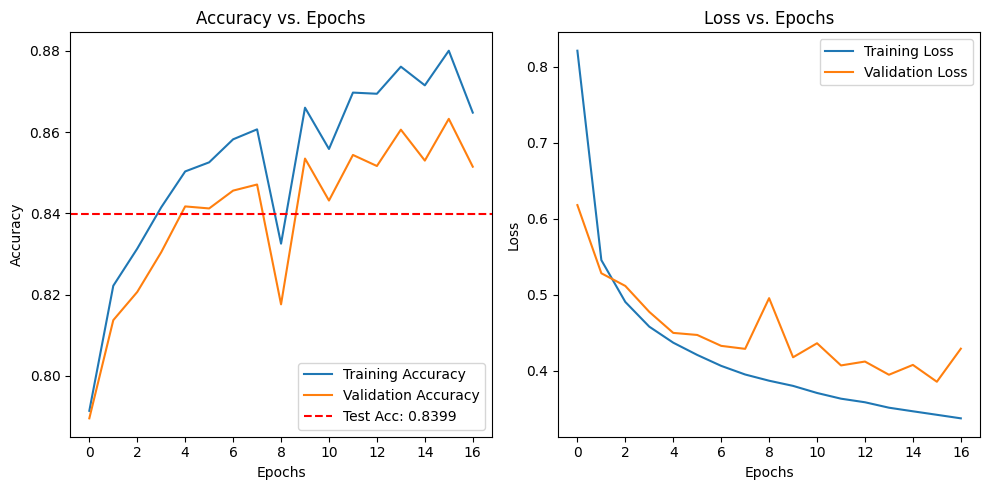

Early Stopping - Test Accuracy: 0.8399


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, _, _, _ = load_fashion_mnist(data_augmentation=False)

input_size = X_train.shape[1]
output_size = 10

models = {
    'Early Stopping': MLP(input_size, [256], output_size, activation='relu'),
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    train_loss, val_loss, train_acc, val_acc = model.fit(X_train, y_train, X_val, y_val, epochs=30, learning_rate=0.01, batch_size=128, early_stopping=True)

    plt.figure(figsize=(10, 5))

    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    test_acc = model.evaluate_acc(X_test, y_test)

    plt.axhline(
        y=test_acc,
        color='red',
        linestyle='--',
        linewidth=1.5,
        label=f'Test Acc: {test_acc:.4f}'
    )
    plt.legend(loc='lower right')

    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"{name} - Test Accuracy: {test_acc:.4f}")

